In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


In [2]:
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

Babi has 931 images
Calimerio has 353 images
Chrysanthemum has 696 images
Hydrangeas has 518 images
Lisianthus has 969 images
Pingpong has 360 images
Rosy has 171 images
Tana has 623 images
Processed 3696 training files.
Processed 925 testing files.


In [4]:
# Defining the imagedatagenerator for train and test image for pre-processing
# We don't give horizonal_flip or other preprocessing for validation data generator
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True)
valid_data_gen = ImageDataGenerator(rescale = 1./255)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 4445 images belonging to 8 classes.
Found 1674 images belonging to 8 classes.


In [5]:
def create_cnn_model(dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation = "softmax"))
    # Compile model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])  
    return model

Epoch 1/10
2/2 [==============================] - 28s 24s/step - loss: 2.1210 - accuracy: 0.0753 - val_loss: 2.0771 - val_accuracy: 0.1322
Epoch 2/10
2/2 [==============================] - 29s 25s/step - loss: 2.0836 - accuracy: 0.1250 - val_loss: 2.0575 - val_accuracy: 0.1911
Epoch 3/10
2/2 [==============================] - 29s 25s/step - loss: 2.0537 - accuracy: 0.1406 - val_loss: 2.0414 - val_accuracy: 0.1935
Epoch 4/10
2/2 [==============================] - 29s 25s/step - loss: 2.0193 - accuracy: 0.1719 - val_loss: 2.0285 - val_accuracy: 0.2037
Epoch 5/10
2/2 [==============================] - 28s 25s/step - loss: 2.0117 - accuracy: 0.2031 - val_loss: 2.0170 - val_accuracy: 0.2139
Epoch 6/10
2/2 [==============================] - 29s 25s/step - loss: 2.0363 - accuracy: 0.2266 - val_loss: 2.0084 - val_accuracy: 0.2133
Epoch 7/10
2/2 [==============================] - 28s 25s/step - loss: 2.0132 - accuracy: 0.2031 - val_loss: 2.0024 - val_accuracy: 0.2133
Epoch 8/10
2/2 [===========

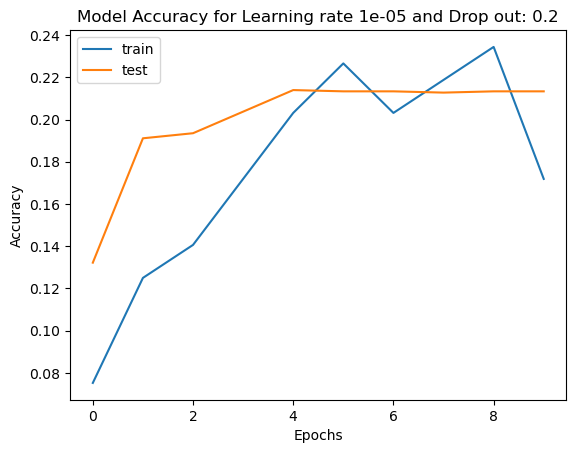

Epoch 1/10
2/2 [==============================] - 28s 24s/step - loss: 2.1679 - accuracy: 0.1250 - val_loss: 2.0821 - val_accuracy: 0.1352
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 2.1455 - accuracy: 0.0859

KeyboardInterrupt: 

In [27]:
models = []
lr_params = [1e-5, 1e-4, 1e-3, 1e-2]
dropout_params = [0.2, 0.4]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

for lr in lr_params:
    for dropout in dropout_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=100,
        verbose=1, callbacks=[early_stopping])
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)
